### SMS Spam Classification with Naive Bayes

In [1]:
import math
from collections import Counter
import re
import numpy as np
import pandas as pd 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import svm
# from nltk.tokenize import TreebankWordTokenizer
from nltk.corpus import stopwords
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn import metrics
from sklearn import tree
import scattertext as st
from pprint import pprint
import operator
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import OrderedDict
from sklearn.model_selection import cross_val_score

### Tokenization: 
1. Remove non-alphanumeric characters and stopwords
2. Remove words with length 2 or less (usually add more noise than good to the classifier) 
3. All words will not be lowercased
4. Word Bi-grams will be added to vocabset

In [9]:
filename = 'sms_data'
sms_df = pd.read_csv(filename, header=None, sep='	', names=['class_sms', 'sms'])

sms_df['sms'] = sms_df['sms'].str.replace(r'\d+', '')
sms_df['sms'] = sms_df['sms'].str.replace(r'\W*\b\w{1,2}\b', '') # regex for replacing words of len less then 2
sms_df['sms'] = sms_df['sms'].apply(lambda x: x.split())
sms_df['sms'] = sms_df['sms'].apply(lambda x: ','.join(x))

# sms_df.loc[sms_df['class_sms'] == 'spam'].to_csv('spam_fi2.csv')  # created a new csv with only spam data
# sms_df.loc[sms_df['class_sms']=='spam'].apply(lambda x: x.split())

X = sms_df.sms
y = sms_df.class_sms

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
stopword = stopwords.words('english')
stopword.append('You')
stopword.append('Your')
vect = CountVectorizer(token_pattern=u'(?u)\\b\\w+\\b', lowercase=False, ngram_range=(1,2), stop_words=stopword)

X_train_dtm = vect.fit_transform(X_train) 
X_test_dtm = vect.transform(X_test)

nb = MultinomialNB()
nb.fit(X_train_dtm, y_train)
y_pred_class = nb.predict(X_test_dtm)  

confusion_matrix = metrics.confusion_matrix(y_test, y_pred_class)
false_positive_rate = confusion_matrix[1][0] / (confusion_matrix[1][0] + confusion_matrix[1][1])
false_negative_rate = confusion_matrix[0][1] / (confusion_matrix[0][0] + confusion_matrix[0][1])

print(confusion_matrix)
print('General Accuracy:', metrics.accuracy_score(y_test, y_pred_class)) # 0.9885
print('False Positive Rate:', false_positive_rate*100) 
print('False Negative Rate:', false_negative_rate*100) 
print (classification_report(y_test, y_pred_class))

[[1203    7]
 [  10  174]]
General Accuracy: 0.987804878049
False Positive Rate: 5.4347826087
False Negative Rate: 0.578512396694
             precision    recall  f1-score   support

        ham       0.99      0.99      0.99      1210
       spam       0.96      0.95      0.95       184

avg / total       0.99      0.99      0.99      1394



Common Spam Value Visualization

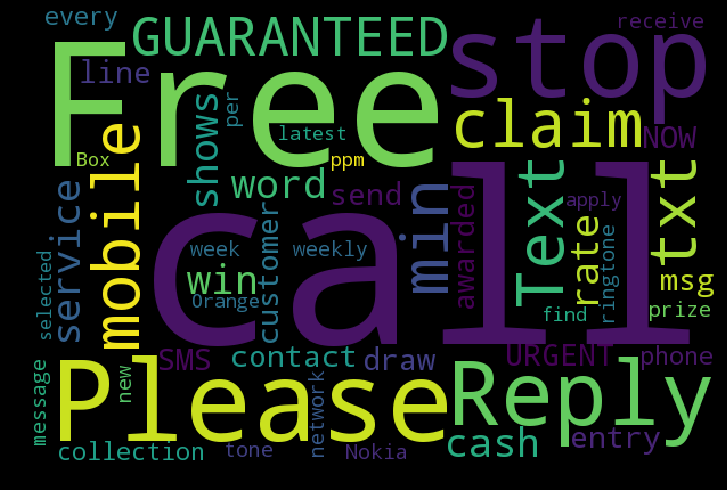

In [3]:
spam_token_count = nb.feature_count_[1, :] 
X_train_tokens = vect.get_feature_names()
tokens = pd.DataFrame({'token':X_train_tokens, 'spam':spam_token_count})
tokens['spam'] = tokens.spam + 1
tokens['spam'] = tokens.spam / nb.class_count_[1]
spam_words = tokens.sort_values('spam', ascending=False)
spam_words = list(spam_words.token)[:70]
spam_wordcloud = WordCloud(width=600, height=400).generate(' '.join(spam_words))
plt.figure( figsize=(10,8), facecolor='k')
plt.imshow(spam_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show() 
# print(tokens.sort_values('spam', ascending=False))  

In [ ]:
# Displaying both the FP and FN 
# Working on lowering the FP Rate

In [8]:
false_positive = X_test[(y_test == 'spam') & (y_pred_class == 'ham')]
false_negative = X_test[(y_test == 'ham') & (y_pred_class == 'spam')]
print(false_positive)
print(false_negative)

1875    Would,you,like,see,XXX,pics,they,are,hot,they,...
4069    TBS/PERSOLVO.,been,chasing,since,Sept,for£,def...
2247    babe,goten,bout?',scammers,getting,smart..Thou...
684     sue,years,old,and,work,lapdancer,love,sex.,Tex...
2823    ROMCAPspam,Everyone,around,should,responding,w...
1328    balance,now,next,question:,Who,sang,'Uptown,Gi...
Name: sms, dtype: object
4773    ,,Mobile;,has,added,you,their,contact,list,www...
4019         GRAN,ONLYFOUND,OUT,AFEW,DAYS,AGO.CUSOON,HONI
4702                                 liked,the,new,mobile
2379    ,,Mobile;,has,added,you,their,contact,list,www...
4207                                    Get,the,door,here
2652    Text,when,you,get,off,,don,call,phones,having,...
3692    Sir,waiting,for,your,call,,once,free,please,call.
3415                                    pic.,Please-send.
Name: sms, dtype: object


### Using various feature selection methods to help improve accuracy 
(Inspired by: http://citeseerx.ist.psu.edu/viewdoc/download;jsessionid=091A511BBB3D220945316240C0A7D1C1?doi=10.1.1.32.9956&rep=rep1&type=pdf) 
1. Document Freqeuency thresholding
2. Information Gain
3. Mutual Information 
4. Chi Statistic
5. Term Strength 

1. Document Freqeuency thresholding

In [35]:
# vect = CountVectorizer(token_pattern=u'(?u)\\b\\w+\\b', lowercase=False, stop_words=stopword)
# X_train_dtm = vect.fit_transform(X_train) 
# vocabSet = vect.get_feature_names()
# sms_df['freq'] = sms_df.groupby('sms')['sms'].transform('count')
# for word in vocabSet:
#     if sms_df['sms'].str.contains(word):
#         sms_df['freq'] = sms_df[]        
# #         df['freq'] = df.groupby('a')['a'].transform('count')
#         sms_df['freq'] = sms_df.groupby('sms')['sms'].transform('count')
# print(sms_df)
sms_df['sms'] = sms_df['sms'].apply(lambda x: pd.value_counts(x.split(" "))).sum(axis = 0)
print(sms_df['sms'])

AttributeError: 'float' object has no attribute 'split'

In [12]:
def gain(data, class_label, target_attr):
    spam_val_freq = {}
    ham_val_freq = {}
    total_val_freq = {}
    subset_entropy = 0.0

    # Calculate the frequency of each of the values in the target attribute
    for i in range(len(data)):
        if class_label[i] == target_attr:
            y = data[i]
            y = y.split(',')
            for word in y:
                if word in spam_val_freq:
                    spam_val_freq[word] += 1
                else:
                    spam_val_freq[word] = 1   
                    
        if class_label[i] != target_attr:
            y = data[i]
            y = y.split(',')
            for word in y:
                if word in ham_val_freq:
                    ham_val_freq[word] += 1
                else:
                    ham_val_freq[word] = 1 
    
    for word in spam_val_freq:
        if word in ham_val_freq:
            total_val_freq[word] = spam_val_freq[word] + ham_val_freq[word]
        else:
            total_val_freq[word] = 1
    
    prob_ham = len(sms_df.loc[sms_df['class_sms'] == 'spam']) / len(X)
    prob_spam = len(sms_df.loc[sms_df['class_sms'] == 'ham']) / len(X)
    total_entropy = -(prob_ham) * math.log(prob_ham, 2) - prob_spam * math.log(prob_spam, 2)

    # calculation of conditional entropy 
    entropy_dict = {}
    for word in spam_val_freq:
        spam_val_prob = spam_val_freq[word] / total_val_freq[word]
#         ham_val_prob = ham_val_freq[word] / total_val_freq[word]
        entropy = -(spam_val_prob)*math.log(spam_val_prob, 2) 
#         entropy = -(spam_val_prob)*math.log(spam_val_prob, 2) - ham_val_prob*math.log(ham_val_prob, 2)
        word_entropy = total_entropy - entropy
        if len(word) > 1:   
            entropy_dict[word] = word_entropy
    entropy_dict = sorted(entropy_dict.items(), key=operator.itemgetter(1), reverse=True)
    return entropy_dict[:200]

In [20]:
entropy_dict = gain(X, y, 'spam')
# entropy_dict = [list(i).append('spam') for i in entropy_dict]
new_li = []
for i in entropy_dict:
    i = list(i)
    i.append('spam')
    new_li.append(i)
new_df = pd.DataFrame(new_li, columns=['sms', 'entropy_level', 'class_sms'])
new_df1 = new_df[['sms', 'class_sms']]
sms_df = sms_df.append(new_df1, ignore_index=True)

X = sms_df.sms
y = sms_df.class_sms

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
# stopword = stopwords.words('english')
# stopword.append('You')
# stopword.append('Your')
# vect = CountVectorizer(token_pattern=u'(?u)\\b\\w+\\b', lowercase=False, ngram_range=(1,2), stop_words=stopword)

X_train_dtm = vect.fit_transform(X_train) 
X_test_dtm = vect.transform(X_test)    
nb = MultinomialNB()
nb.fit(X_train_dtm, y_train)

y_pred_class = nb.predict(X_test_dtm)  
confusion_matrix = metrics.confusion_matrix(y_test, y_pred_class)
false_positive_rate = confusion_matrix[1][0] / (confusion_matrix[1][0] + confusion_matrix[1][1])
false_negative_rate = confusion_matrix[0][1] / (confusion_matrix[0][0] + confusion_matrix[0][1])

print(confusion_matrix)
print('General Accuracy:', metrics.accuracy_score(y_test, y_pred_class)) # 0.9885
print('False Positive Rate:', false_positive_rate*100) 
print('False Negative Rate:', false_negative_rate*100) 
print (classification_report(y_test, y_pred_class))

[[1185   10]
 [  28  521]]
General Accuracy: 0.978211009174
False Positive Rate: 5.10018214936
False Negative Rate: 0.836820083682
             precision    recall  f1-score   support

        ham       0.98      0.99      0.98      1195
       spam       0.98      0.95      0.96       549

avg / total       0.98      0.98      0.98      1744



In [21]:
spam_token_count = nb.feature_count_[1, :] 
X_train_tokens = vect.get_feature_names()
tokens = pd.DataFrame({'token':X_train_tokens, 'spam':spam_token_count})
tokens['spam'] = tokens.spam + 1
tokens['spam'] = tokens.spam / nb.class_count_[1]
print(tokens.sort_values('spam', ascending=False))  # Common Spam Value Predictor list

           spam          token
11753  0.091990           call
2481   0.065707           FREE
1267   0.065707           Call
32241  0.051314            www
24550  0.050063          prize
8080   0.045682            Txt
21715  0.042553         mobile
30274  0.041927            txt
12569  0.041302          claim
28900  0.035044           text
13140  0.034418        contact
6602   0.033792           STOP
12158  0.031289           cash
16129  0.030038           free
31368  0.030038           week
8148   0.026283         URGENT
25400  0.026283          reply
1509   0.025657          Claim
5234   0.025657            NOW
24380  0.025031            ppm
26587  0.024406        service
28026  0.024406           stop
5377   0.024406          Nokia
29833  0.024406           tone
12801  0.023780            com
2703   0.023780           Free
16549  0.023780            get
10525  0.022528        awarded
26428  0.022528           send
7547   0.021902           Text
...         ...            ...
12867  0

In [6]:
## Cool Library that provides html graph visualization of the common words for both classes

# nlp = st.WhitespaceNLP.whitespace_nlp
# corpus = st.CorpusFromPandas(sms_df, 
#                               category_col='class_sms', 
#                               text_col='sms',
#                               nlp=nlp).build()
# term_freq_df = corpus.get_term_freq_df()
# term_freq_df['spam'] = corpus.get_scaled_f_scores('spam')
# pprint(list(term_freq_df.sort_values(by='spam', ascending=False).index[:10])) # words most associated with spam
# term_freq_df['ham'] = corpus.get_scaled_f_scores('ham')
# pprint(list(term_freq_df.sort_values(by='ham', ascending=False).index[:10]))  # words most associated with ham
# html = st.produce_scattertext_explorer(corpus,
#           category='spam',
#           category_name='spam',
#           not_category_name='ham',
#           width_in_pixels=1000,
#           )
# open("Convention-Visualization.html", 'wb').write(html.encode('utf-8'))